In [213]:
import numpy
from matplotlib import pyplot as plt
import h5py
import glob
from scipy import signal
import matplotlib.mlab as mlab
plt.ion()

#specifying dir to which files are saved
fdir='/Users/thomasmosher/Phys512/problem_sets/LOSC_Event_Tutorial/'


def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    gpsStart=meta['GPSstart'].value
    #print meta.keys()
    utc=meta['UTCstart'].value
    duration=meta['Duration'].value
    strain=dataFile['strain']['Strain'].value
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

#making a list of each of the files in order to search for events
fname_H = [fdir+'H-H1_LOSC_4_V2-1126259446-32.hdf5',fdir+'H-H1_LOSC_4_V2-1135136334-32.hdf5',fdir+'H-H1_LOSC_4_V2-1128678884-32.hdf5',
fdir+'H-H1_LOSC_4_V1-1167559920-32.hdf5']

fname_L = [fdir+'L-L1_LOSC_4_V2-1126259446-32.hdf5',fdir+'L-L1_LOSC_4_V2-1135136334-32.hdf5',fdir+'L-L1_LOSC_4_V2-1128678884-32.hdf5',
           fdir+'L-L1_LOSC_4_V1-1167559920-32.hdf5']

templates = [fdir+'GW150914_4_template.hdf5',fdir+'GW151226_4_template.hdf5',fdir+'LVT151012_4_template.hdf5',fdir+'GW170104_4_template.hdf5']

temp_name = ['GW150914','GW151226','LVT151012','GW170104']


#making empty lists to append the values from each of the files
strain_H, utc_H = [],[]

strain_L, utc_L = [],[]

th, tl = [],[]

#reading each of the templates
for i in range(len(fname_H)):
    print('reading Hanford file ',fname_H[i])
    print('reading Livingston file ',fname_L[i])
    print('reading corresponding template ',templates[i])
    # save Hanford data
    strainH,dt_H,utcH=read_file(fname_H[i])
    # save Livingston data
    strainL,dt_L,utcL=read_file(fname_L[i])
    # saving template
    t_h,t_l=read_template(templates[i])
    
    strain_H.append(strainH)
    utc_H.append(utcH)
    
    strain_L.append(strainL)
    utc_L.append(utcL)
    
    th.append(t_h)
    tl.append(t_l)


reading Hanford file  /Users/thomasmosher/Phys512/problem_sets/LOSC_Event_Tutorial/H-H1_LOSC_4_V2-1126259446-32.hdf5
reading Livingston file  /Users/thomasmosher/Phys512/problem_sets/LOSC_Event_Tutorial/L-L1_LOSC_4_V2-1126259446-32.hdf5
reading corresponding template  /Users/thomasmosher/Phys512/problem_sets/LOSC_Event_Tutorial/GW150914_4_template.hdf5
reading Hanford file  /Users/thomasmosher/Phys512/problem_sets/LOSC_Event_Tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5
reading Livingston file  /Users/thomasmosher/Phys512/problem_sets/LOSC_Event_Tutorial/L-L1_LOSC_4_V2-1135136334-32.hdf5
reading corresponding template  /Users/thomasmosher/Phys512/problem_sets/LOSC_Event_Tutorial/GW151226_4_template.hdf5
reading Hanford file  /Users/thomasmosher/Phys512/problem_sets/LOSC_Event_Tutorial/H-H1_LOSC_4_V2-1128678884-32.hdf5
reading Livingston file  /Users/thomasmosher/Phys512/problem_sets/LOSC_Event_Tutorial/L-L1_LOSC_4_V2-1128678884-32.hdf5
reading corresponding template  /Users/thomasmosher/P

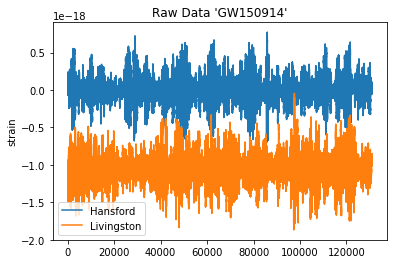

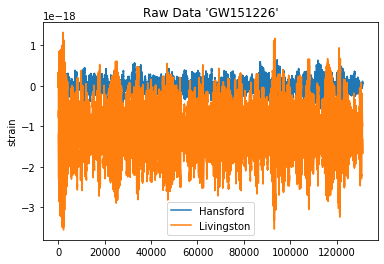

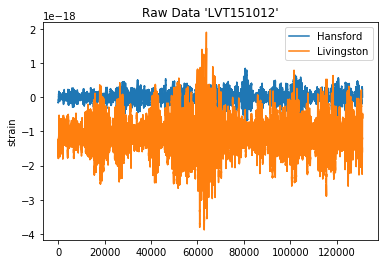

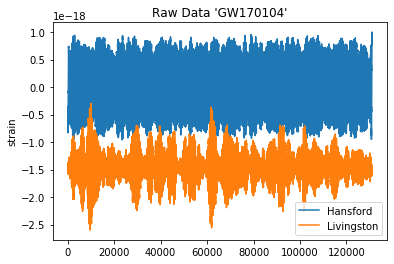

In [262]:
#plotting the Hansford and Livingston strains from each file

for i in range(len(fname_H)):
    plt.plot(strain_H[i],label='Hansford')
    plt.plot(strain_L[i],label='Livingston')
    plt.title('Raw Data '+ repr(temp_name[i]))
    plt.ylabel('strain')
    plt.legend()
    plt.show()



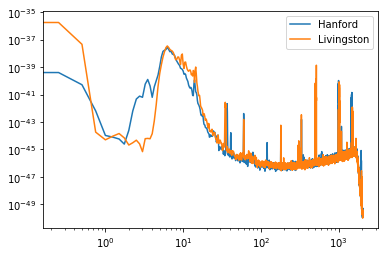

In [192]:
# Plotting the power spectrum for the first template to get an idea of what we're looking at
#using a blackman window
samp = int(1/dt_L)

NFFT = 4*samp # use 4 seconds of data for each fourier transform
n_overlap = NFFT/2 # overlap half the points

psd_window = signal.blackman(NFFT)

PSD_H, freq = mlab.psd(strain_H[0], Fs=samp, NFFT=NFFT, window=psd_window, noverlap=n_overlap)
PSD_L, freq = mlab.psd(strain_L[0], Fs=samp, NFFT=NFFT, window=psd_window, noverlap=n_overlap)

plt.loglog(freq, PSD_H, label='Hanford')
plt.loglog(freq, PSD_L, label='Livingston')
plt.legend()
plt.show()





## a)

Here I generate a noise model by taking the strain and windowing with a blackman window and then fourier transforming and squaring the value to get the power spectrum which can be taken as the noise model. The power spectrum is then smoothed by applying a Gaussian filter. I did not deal with the lines that do not correspond to the gravitaitonal waves.

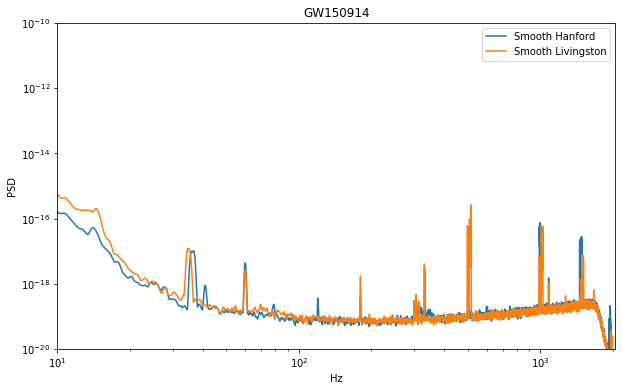

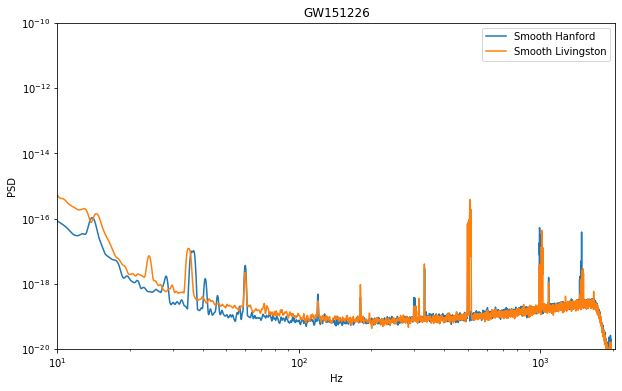

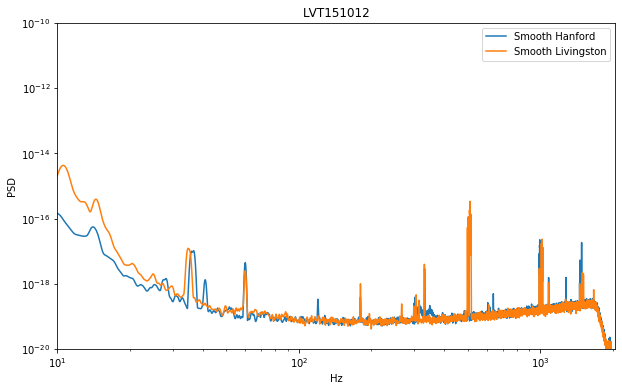

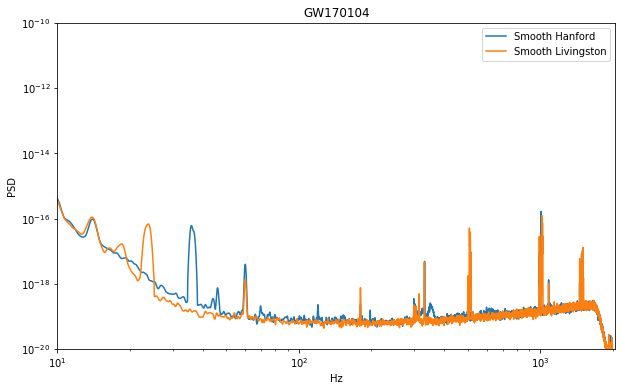

In [292]:
import numpy as np
from scipy.ndimage import gaussian_filter as gauss



Smo_N_L, Smo_N_H = [],[]

strain_H_fft, strain_L_fft= [],[]

#finding the frequencies using corresponding to the power sampling rate
#sampling rate is the same for each of the events
fft_freq = np.fft.rfftfreq(len(strain_H[0]), dt_H)
#shifting the frequency so they make more sense for our model
fft_freq= np.fft.fftshift(fft_freq)

#using a blackman window in order to more easily process the spectrum

#blackman window appeared to produce the best results
dwindow=np.blackman(len(strain_H[0]))

for i in range(len(fname_H)):

    #windowing the data and taking the fourier transform of the data 
    #and the template (with dwindow) in order to compute the power spectrum
    H_win=strain_H[i]*dwindow
    L_win=strain_L[i]*dwindow
    strainH_fft = np.fft.rfft(H_win) #/ samp
    strainL_fft = np.fft.rfft(L_win) #/ samp
    
    
    strain_H_fft.append(strainH_fft)
    strain_L_fft.append(strainL_fft)
    #this is our power spectrum which will be used as the noise
    N_H=np.abs(strainH_fft)**2
    N_L=np.abs(strainL_fft)**2

    #Now I smooth the power spectrum with a Gaussian filter and 10 standard deviation
    Smo_N_H.append(gauss(N_H, 10))
    Smo_N_L.append(gauss(N_L, 10))

    # Tried cutting off the non-physical data near the start but this
    #stop the next steps from working
    #Smo_N_H[i][0:50]=0
    #Smo_N_L[i][0:50]=0
    

    plt.figure(figsize=(10,6))
    plt.title(temp_name[i])
#plt.loglog(fft_freq, N_H, label='Hanford')
    plt.loglog(fft_freq, np.sqrt(np.fft.fftshift(Smo_N_H[i])), label='Smooth Hanford')
    plt.xlabel('Hz')
    plt.ylabel('PSD')
#plt.xlim(freq[0],freq[-1])
#plt.ylim(1e-47,1e-25)
#plt.legend()


#plt.loglog(fft_freq, N_L, label='Livingston')
    plt.loglog(fft_freq, np.sqrt(np.fft.fftshift(Smo_N_L[i])), label='Smooth Livingston')
    plt.xlabel('Hz')
    plt.ylabel('PSD')
    plt.xlim(10,freq[-1])
    plt.ylim(1e-20,1e-10)
    plt.legend()


    plt.show()

#nothing was done to deal with lines

## b)

Here we are generating a match filter using out best fit model
$$ m = (A^T N^{-1}d)(A^T N^{-1}A)^{-1} $$

Where $A$ is our template, d is the data and N is the noise that is assumed to be uncorrelated

In order to fit our data we must whiten it and we do this using:

$$ m = (A^T N^{-1/2}N^{-1/2}d)(A^T N^{-1/2}N^{-1/2}A)^{-1} = [(N^{-1/2}A)^T (N^{-1/2}d)] [(N^{-1/2}A)^T (N^{-1/2}A)]^{-1} $$

So that the model we are fitting is $N^{-1/2}A$ and our modified data is $N^{-1/2}d$.


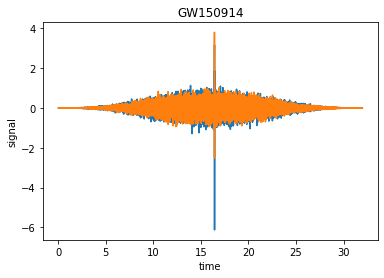

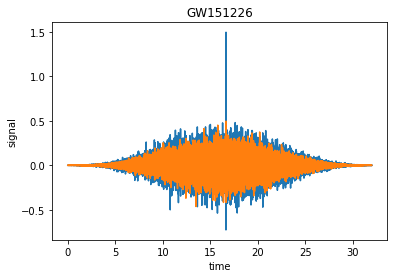

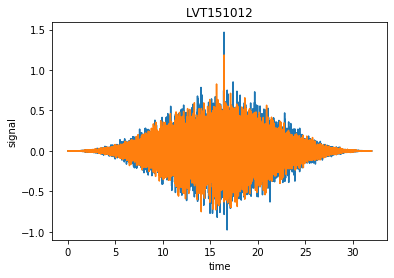

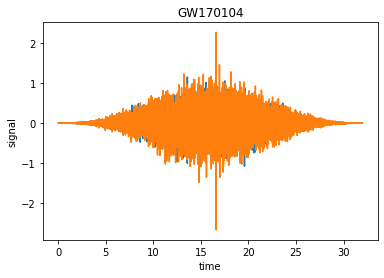

In [289]:
fft_th,fft_tl=[],[]
mat_fil_H,mat_fil_L=[],[]
th_white, tl_white=[],[]


for i in range(len(fname_H)):
    #dividing out strain data in fourier space by the smoothed noise to make our model
    whiten_H=strain_H_fft[i]/np.sqrt(Smo_N_H[i])
    #taking the fouriter transform of our template with the window
    Fft_th=np.fft.rfft(th[i]*dwindow)
    #making the model for our template in the same way
    th_whiteH=Fft_th/np.sqrt(Smo_N_H[i])
    
    #our match filter is the conjugate of the template with the data
    #then we take the inverse fourier transform
    mat_filH=np.fft.irfft(np.conj(th_whiteH)*whiten_H)
    
    fft_th.append(Fft_th)
    mat_fil_H.append(mat_filH)
    th_white.append(th_whiteH)

    #doing the same for livingston
    whiten_L=strain_L_fft[i]/np.sqrt(Smo_N_L[i])
    Fft_tl=np.fft.rfft(tl[i]*dwindow)
    tl_whiteL=Fft_tl/np.sqrt(Smo_N_L[i])
    mat_filL=np.fft.irfft(np.conj(tl_whiteL)*whiten_L)
    
    fft_tl.append(Fft_tl)
    mat_fil_L.append(mat_filL)
    tl_white.append(tl_whiteL)

#getting our time values to plot with the match filter
t=np.fft.fftfreq(len(strain_H[0]), samp)*len(strain_H[0])
t=t-np.min(t)

#plotting the match filter for each event with Hansford and Livingston
for i in range(len(fname_H)):
    plt.plot(t, mat_fil_H[i])
    plt.plot(t, mat_fil_L[i])
    plt.title(temp_name[i])
    plt.xlabel('time')
    plt.ylabel('signal')
    plt.show()

## c)

The noise is take as the square root of the covariance matrix given by
$$ <m m^T> \ = \ <(A^T N^{-1}A)^{-1}A^T N^{-1}d \, d^T N^{-1}A \, (A^T N^{-1}A)^{-1}> $$

because the gravitation waves contribution is small we assume $dd^T\approx N$. So
$$ <m m^T> \ = \ <(A^T N^{-1}A)^{-1})>$$

and our noise can be taken as the square root of this matrix

For this procedure we will take the signal from the template in fourier space which we had earlier and divide by the noise model we generated above then we will transform it back into normal space


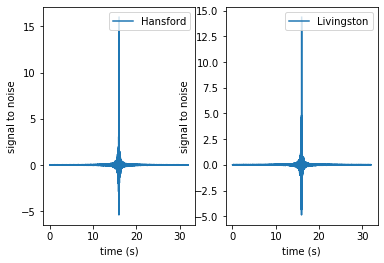

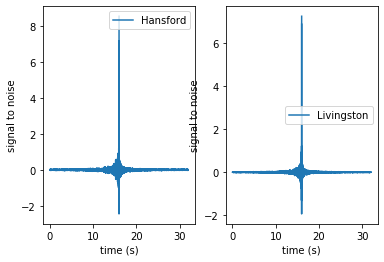

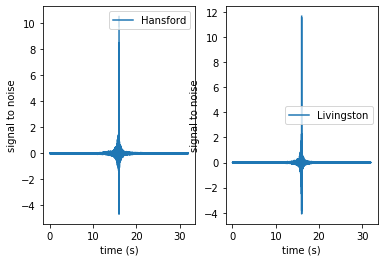

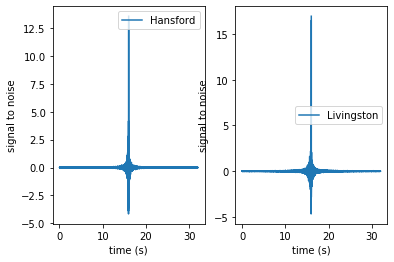

In [266]:
SNR_H,SNR_L=[],[]
for i in range(len(fname_H)):
    
    #calculating the signal to noise ratio squared from the template and the smoothed
    #noise model we found in fourier space
    SNR_h_fft=((fft_th[i]**2)/Smo_N_H[i])
    SNR_l_fft=((fft_tl[i]**2)/Smo_N_L[i]) 
    #taking the square root to find the SNR and then reverse fourier transform
    SNR_H.append(np.fft.irfft(np.sqrt(SNR_h_fft)))
    SNR_L.append(np.fft.irfft(np.sqrt(SNR_l_fft)))

for i in range(len(fname_H)):
    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(t, SNR_H[i],label='Hansford')
    plt.xlabel("time (s)")
    plt.ylabel("signal to noise")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(t, SNR_L[i],label='Livingston')
    plt.xlabel("time (s)")
    plt.ylabel("signal to noise")
    plt.legend()
    plt.show()




Here I print out the signal to noise ratio for each of the peaks in the events which are assumed to be the gravitational wave signal. I also print out a signal to noise ration from the scatter of the matched filter in order to compare for part D.

The combined SNRs are calculated by adding the Livingston and Hansford SNR values in quadrature

In [281]:



for i in range(len(fname_H)):
    print('For event'+repr(temp_name[i])+':')
    #finding the index of the peak ie the GW wave in the Hansford model     
    h_max=np.argmax(abs(mat_fil_H[i])) #finding the location of the wave assuming its the highest piont in the peak
    
    #calculating an SNR from the scatter by taking the
    #noise to be the standard from frequencies around the peak
    SNR_est_H=mat_fil_H[i][h_max]/np.std(mat_fil_H[i][h_max-500:h_max+500])
    #printing out the SNR signal that are determined
    print('the analytic signal to noise is '+repr(abs(np.max(SNR_H[i])))+' the scatter SNR '+repr(abs(SNR_est_H))+' for Hansford')

    #repeating the process for the livingston model
    l_max=np.argmax(abs(mat_fil_L[i]))
    SNR_est_L=mat_fil_L[i][l_max]/np.std(mat_fil_L[i][l_max-500:l_max+500])
    print('analytic signal to noise is '+repr(abs(np.max(SNR_L[i])))+' the scatter SNR '+repr(abs(SNR_est_L))+' for Livingston')
    
    print('The combined analytical SNR is ' +repr(abs(np.sqrt(np.max(SNR_L[i])**2+np.max(SNR_H[i])**2)))+
          ' and the combined scatter SNR is '+repr(abs(np.sqrt(np.max(SNR_est_L)**2+np.max(SNR_est_H)**2))))

For event'GW150914':
the analytic signal to noise is 15.994041574533163 the scatter SNR 8.149169787316055 for Hansford
analytic signal to noise is 14.348028834702195 the scatter SNR 7.521972924666975 for Livingston
The combined analytical SNR is 21.48663066488883 and the combined scatter SNR is 11.090042601447834
For event'GW151226':
the analytic signal to noise is 8.546296120689256 the scatter SNR 6.228227781498953 for Hansford
analytic signal to noise is 7.254820461222106 the scatter SNR 3.810712658825278 for Livingston
The combined analytical SNR is 11.21033439764734 and the combined scatter SNR is 7.301530816641575
For event'LVT151012':
the analytic signal to noise is 10.535673933847375 the scatter SNR 5.393980274124453 for Hansford
analytic signal to noise is 11.66677079259697 the scatter SNR 4.947391466361039 for Livingston
The combined analytical SNR is 15.71985896779436 and the combined scatter SNR is 7.3192694662149
For event'GW170104':
the analytic signal to noise is 13.57080

## d)

## e)

Here we calculate the frequency for each event at which half the weight is above and half is below. This is done by calculating the max of the power spectrum and taking half of that value and finding it's index to find the corresponding frequency 

For'GW150914'The halfway points 104.75 Hz for Hansford and 117.21875 Hz for Livingston
For'GW151226'The halfway points 82.15625 Hz for Hansford and 108.625 Hz for Livingston
For'LVT151012'The halfway points 82.90625 Hz for Hansford and 98.375 Hz for Livingston
For'GW170104'The halfway points 94.0625 Hz for Hansford and 76.125 Hz for Livingston


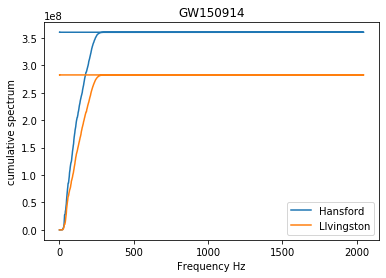

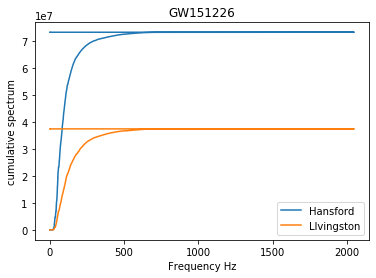

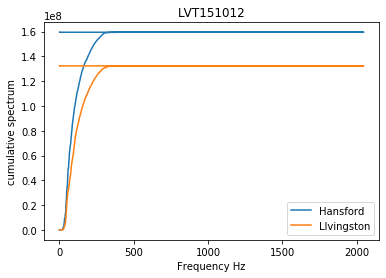

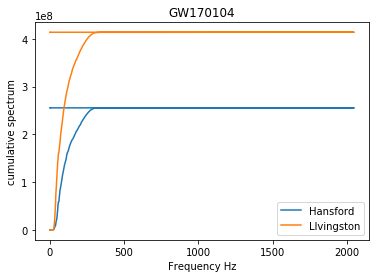

In [279]:
fft_freq=np.fft.fftshift(fft_freq)

for i in range(len(fname_H)):
    #Taking the power spectrum for each of the events
    Psh=np.abs(th_white[i]**2)
    Psl=np.abs(tl_white[i]**2)
    
    
    ##calculated a cumulative power spectrum in order to find the halfway point
    scaled_ps_H=np.cumsum(Psh)
    scaled_ps_L=np.cumsum(Psl)
    half_max_H=max(scaled_ps_H)/2.
    half_max_L=max(scaled_ps_L)/2.
    
    #taking abs value of the cum power spectrum and subtracting the half max value
    n = [abs(l-half_max_H) for l in scaled_ps_H]
    #finding the index at which this value is lowest as it will be closest to the half max
    k=n.index(min(n))
    
    #repeating for livingston
    m = [abs(l-half_max_L) for l in scaled_ps_L]
    j=m.index(min(m))
    
    
    print('For'+repr(temp_name[i])+'The halfway points',np.abs(fft_freq[k]),'Hz for Hansford and',np.abs(fft_freq[j]),"Hz for Livingston")
    
    #plotting the cumulative power spectrums 
    plt.figure()
    plt.step(fft_freq,scaled_ps_H,label='Hansford')
    plt.step(fft_freq,scaled_ps_L,label='LIvingston')
    #plt.title(GWs[i])
    plt.legend()
    plt.title(temp_name[i])
    plt.xlabel('Frequency Hz')
    plt.ylabel('cumulative spectrum')

## f)

Here we find the time at which each detector find the gravitational wave by finding the index of the peak and finding the corresponding time

In [280]:


for i in range(len(fname_H)):
    print('For event'+repr(temp_name[i])+':')
          
    h_max=np.argmax(abs(mat_fil_H[i])) #finding the location of the wave assuming its the highest piont in the peak

    l_max=np.argmax(abs(mat_fil_L[i]))
 
    print('the event was measured at',t[h_max],'in the Hansford')
    print('the event was measured at',t[l_max],'in the Livingston')

For event'GW150914':
the event was measured at 16.4404296875 in the Hansford
the event was measured at 16.431640625 in the Livingston
For event'GW151226':
the event was measured at 16.647705078125 in the Hansford
the event was measured at 16.647705078125 in the Livingston
For event'LVT151012':
the event was measured at 16.44140625 in the Hansford
the event was measured at 16.443359375 in the Livingston
For event'GW170104':
the event was measured at 16.60791015625 in the Hansford
the event was measured at 16.61279296875 in the Livingston
